In [77]:
# System Library
import os

# Data Wrangling Libraries
import pandas as pd
import numpy as np
import json
import textwrap
from termcolor import colored

# Machine Learning Libraries
import torch 
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from tqdm.auto import tqdm


# Graph Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize']=16,10


In [78]:
with open('../Dataset/bbc-news-data.csv', 'r') as f:
    df_header = f.readline().split()
df = pd.read_csv('../Dataset/bbc-news-data.csv', names=df_header, sep='\t', skiprows=1)
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [79]:
print(df.category.value_counts())
category_spread = (df.category.value_counts() / df.shape[0]) * 100

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


In [80]:
category_spread.values

array([22.96629213, 22.92134831, 18.74157303, 18.02247191, 17.34831461])

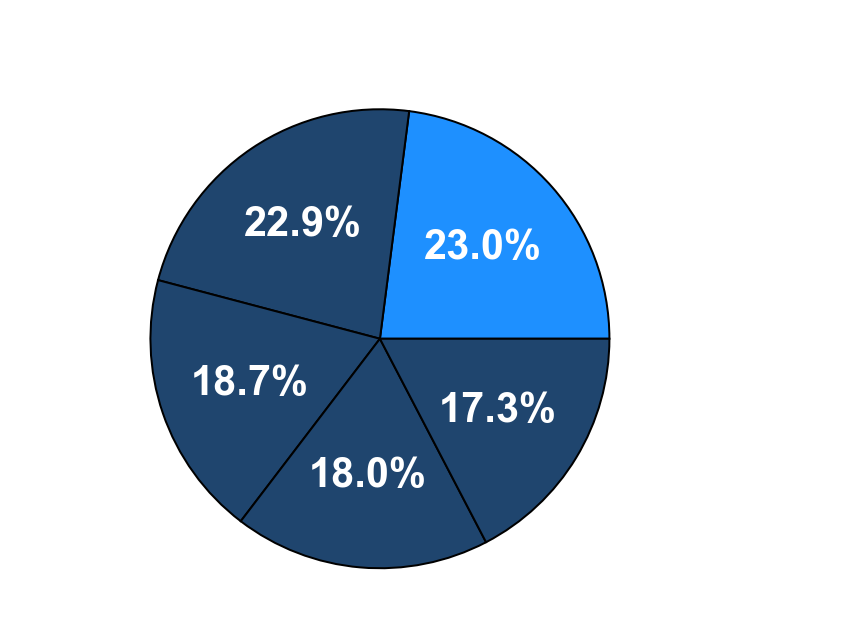

In [81]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.get_cmap('Greys')
colors = ['dodgerblue','#1F456E', '#1F456E', '#1F456E', '#1F456E']



patches, texts, pcts = ax.pie(category_spread.values, 
                                labels=category_spread.index, 
                                autopct='%.1f%%', 
                                colors=colors,
                                wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'},
                                textprops={'size': 'x-large', 'color':  'white', 'variant': 'small-caps'})
ax.set_title('News Article Category', fontsize=18, color='white')
plt.setp(pcts, color='white', fontweight='bold')
plt.tight_layout()

In [82]:
print(df.isnull().value_counts())
print(df.shape)

category  filename  title  content
False     False     False  False      2225
dtype: int64
(2225, 4)


In [89]:
df['title_length'] = df['title'].apply(lambda x: len(x.split()))
df['content_length'] = df['content'].apply(lambda x: len(x.split()))
df['title'] = df['title'].str.encode('ascii', 'ignore').str.decode('ascii')
df['content'] = df['content'].str.encode('ascii', 'ignore').str.decode('ascii')

In [90]:
category_length = df.groupby('category', 0).agg({'title_length': 'mean', 'content_length': 'mean'})
print(category_length)

               title_length  content_length
category                                   
business           5.396078      323.484314
entertainment      5.424870      325.196891
politics           5.088729      448.884892
sport              4.892368      324.369863
tech               5.266833      497.428928


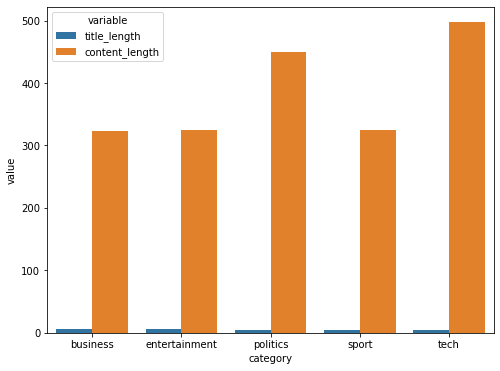

In [62]:
df_m = pd.melt(category_length, ignore_index=False)
plt.figure(figsize=(8,6))
sns.barplot(x=df_m.index, y="value", hue='variable', data=df_m)
plt.show()

In [92]:
X = df['title']
y = df['content']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_df = pd.DataFrame({X_train.name: X_train, y_train.name: y_train})
test_df = pd.DataFrame({X_test.name: X_test, y_test.name: y_test})

In [98]:
print(f"\nXTrain Size: {len(X_train)}\nyTrain Size: {len(y_train)}\nXTest Size: {len(X_test)}\nyTest Size: {len(y_test)}")


XTrain Size: 1780
yTrain Size: 1780
XTest Size: 445
yTest Size: 445


In [99]:
class SummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        title_max_token_len: int = 512,
        content_max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.title_max_token_len = title_max_token_len
        self.content_max_token_len = content_max_token_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        title = data_row['title']

        title_encoding = tokenizer(
            title,
            max_length = self.title_max_token_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = 'pt'
        )

        content = data_row['content']

        content_encoding = tokenizer(
            content,
            max_length = self.content_max_token_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_tensors = 'pt'
        )

        labels = content_encoding['input_ids']
        labels[labels == 0] = -100

        return dict(
            title = title,
            content = content,
            title_input_ids = title_encoding['input_ids'].flatten(),
            text_attention_mask = title_encoding['attention_mask'].flatten(),
            labels = labels.flatten(),
            labels_attention_mask = content_encoding['attention_mask'].flatten()
        )



In [125]:
class SummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_test: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        title_max_token_len: int = 512,
        content_max_token_len: int = 128
    ):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.title_max_token_len = title_max_token_len
        self.content_max_token_len = content_max_token_len
        self.train_df = pd.DataFrame({self.X_train.name: self.X_train, self.y_train.name: self.y_train})
        self.test_df = pd.DataFrame({self.X_test.name: self.X_test, self.y_test.name: self.y_test})

    def setup(self, stage=None):

        self.train_dataset = SummaryDataset(
            self.train_df,
            self.tokenizer,
            self.title_max_token_len,
            self.content_max_token_len
        )

        self.test_dataset = SummaryDataset(
            self.test_df,
            self.tokenizer,
            self.title_max_token_len,
            self.content_max_token_len
        )

        def train_dataloader(self):
            return DataLoader(
                self.train_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=2
            )

        def test_dataloader(self):
            return DataLoader(
                self.test_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=2
            )

        def validation_dataloader(self):
            return DataLoader(
                self.test_dataset,
                batch_size=self.batch_size,
                shuffle=True,
                num_workers=2
            )


In [122]:
MODEL_NAME = 't5-base'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/Users/nidarsh/opt/anaconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [128]:
title_token_counts, content_token_counts = [], []

for _, row in train_df.iterrows():
    title_token_count = len(tokenizer.encode(row['title']))
    title_token_counts.append(title_token_count)

    content_token_count = len(tokenizer.encode(row['content']))
    content_token_counts.append(content_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


In [129]:
EPOCHS = 3
BATCH_SIZE = 8

data_module = SummaryDataModule(X_train=X_train, y_train=y_train, X_test=X_test, 
                        y_test=y_test, tokenizer=tokenizer)